In [109]:
# author - swapnil awasthi
# github - https://github.com/awasthi-swapnil
# start time - Sunday(6/2) - 12 noon
# end time - Monday(6/3) - 12 noon
import os
import pandas as pd
from scipy import stats
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from sklearn import metrics, preprocessing, model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error as mse, accuracy_score, explained_variance_score, roc_auc_score,roc_curve
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
import csv
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from numpy import sort
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing

In [5]:
# function to read the file
def setfilePath(nameofcsvfile):
    file_path=os.getcwd()+'/../'+ nameofcsvfile
    data=pd.read_csv(file_path,index_col=None)
    return data

In [107]:
train=setfilePath('training_data.csv')
test=setfilePath('test_data.csv')
print(train.shape, test.shape)
train.head()

(150000, 12) (101503, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


----
We will follow below steps towards building a base model with basic techniques:
1- Data Ingestion
2- Data cleaning
3- Missing values imputation
4- train-test-split
5- model building
6- model evaluation/validation
7- test set prediction
8- saving predictions to a csv

In [9]:
# find list of columns which has more than 50% of data missing.
def findMissingValueCols(df):
    tmpSeries = df.isnull().sum()
    return tmpSeries.where(tmpSeries>0.50*len(df)).dropna().index.values.tolist()

In [10]:
missingValueColList_train = findMissingValueCols(train)
missingValueColList_test = findMissingValueCols(test)
print(missingValueColList_train,missingValueColList_test)

[] ['SeriousDlqin2yrs']


----
Initial strategy is to drop the columns having more than 50% of values missing. Our training set has none but test set has 'SeriousDlqin2yrs' that has more than 50% values missing. It is because its our target column and would be dropped from training set. We will build a model that will try to predict 'SeriousDlqin2yrs' based on the features provided. 'SeriousDlqin2yrs' can be a good estimate to get to know in advance the applicant's probability of defaulting on a loan.

In [12]:
#train.dtypes
train.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [108]:
train.dtypes

Unnamed: 0                                int64
SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

----
Our train dataset is having missing values in 'MonthlyIncome' and 'NumberOfDependents' columns. We will impute these values after looking at the distribution and stats. We do not have any categorical variable type, therefore no encoding startegy(dummy encoding, one-hot encoding etc.) is required here.

In [13]:
# missing columns stats
print(train['MonthlyIncome'].describe())
print(train['NumberOfDependents'].describe())

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64
count    146076.000000
mean          0.757222
std           1.115086
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64


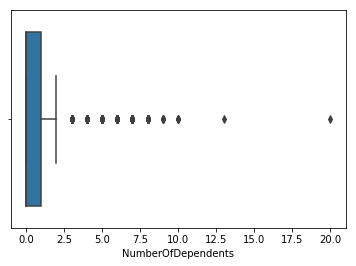

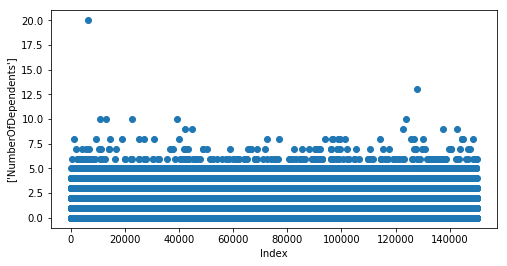

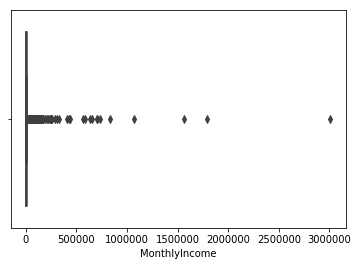

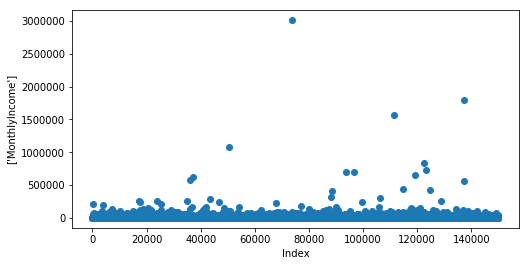

In [14]:
# check the distribution of missing columns - this will help us decide the imputation technique
missing_cols=['NumberOfDependents', 'MonthlyIncome']
for i in range(len(missing_cols)):
    sns.boxplot(x=(train[missing_cols[i]]))
    fig, ax = plt.subplots(figsize=(8,4))
    ax.scatter(train["Unnamed: 0"],train[missing_cols[i]])
    ax.set_xlabel('Index')
    yl=[missing_cols[i]]
    ax.set_ylabel(yl)
    plt.show()

----
We will be using median as imputation technique since it is less effected by the outliers.

In [15]:
# median imputation
train['MonthlyIncome'].fillna(train["MonthlyIncome"].median(), inplace=True)
train['NumberOfDependents'].fillna(train["NumberOfDependents"].median(), inplace=True)

In [16]:
# check
train.isnull().sum()

Unnamed: 0                              0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [23]:
# checking the group distribution
print(train.groupby(['SeriousDlqin2yrs']).size())
train.groupby(['SeriousDlqin2yrs']).size()[1]/(train.groupby(['SeriousDlqin2yrs']).size()[0]+train.groupby(['SeriousDlqin2yrs']).size()[1])

SeriousDlqin2yrs
0    139974
1     10026
dtype: int64


0.06684

----
We have imbalanced class problem here since only 6.684% of our target class is positive(=1). To overcome this, we need to make sure that the sampling done is stratified ensuring equal distribution of classes in train and test dataset.
There are other sophisticated strategies like SMOTE, random downsampling to the majority class etc. that can be used to improve our base model.

In [24]:
# checking the correlation of the variables
corr=(train.corr())
corr.style.background_gradient(cmap='coolwarm')

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
Unnamed: 0,1,0.00280076,0.0023716,0.00440297,-0.000570795,-0.00290563,0.00240038,0.00458554,-0.001104,-0.000665503,-0.00077724,0.000148292
SeriousDlqin2yrs,0.00280076,1,-0.0018015,-0.115386,0.125587,-0.00760212,-0.0171508,-0.0296686,0.117175,-0.00703812,0.102261,0.046869
RevolvingUtilizationOfUnsecuredLines,0.0023716,-0.0018015,1,-0.00589818,-0.0013135,0.0039612,0.00651294,-0.0112807,-0.00106125,0.00623471,-0.00104783,0.00119308
age,0.00440297,-0.115386,-0.00589818,1,-0.0629952,0.0241878,0.027581,0.147705,-0.0610047,0.0331503,-0.0571595,-0.215693
NumberOfTime30-59DaysPastDueNotWorse,-0.000570795,0.125587,-0.0013135,-0.0629952,1,-0.00654192,-0.00836956,-0.0553122,0.983603,-0.0305645,0.987005,-0.00458955
DebtRatio,-0.00290563,-0.00760212,0.0039612,0.0241878,-0.00654192,1,-0.0180061,0.0495653,-0.00831964,0.120046,-0.0075331,-0.0444758
MonthlyIncome,0.00240038,-0.0171508,0.00651294,0.027581,-0.00836956,-0.0180061,1,0.0869492,-0.0105005,0.116273,-0.00925198,0.0663137
NumberOfOpenCreditLinesAndLoans,0.00458554,-0.0296686,-0.0112807,0.147705,-0.0553122,0.0495653,0.0869492,1,-0.0799843,0.433959,-0.0710767,0.0740265
NumberOfTimes90DaysLate,-0.001104,0.117175,-0.00106125,-0.0610047,0.983603,-0.00831964,-0.0105005,-0.0799843,1,-0.0452052,0.992796,-0.0119624
NumberRealEstateLoansOrLines,-0.000665503,-0.00703812,0.00623471,0.0331503,-0.0305645,0.120046,0.116273,0.433959,-0.0452052,1,-0.0397223,0.129399


----
[ 'NumberOfTime60-89DaysPastDueNotWorse',  'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate' ] - 
These 3 columns are highly correlated with each other - which can be a problem in model explainability. 
We can just keep the 'NumberOfTimes90DaysLate' feature since the other 2 appear to be the subset of this feature and may capture the equivalent signal.

In [25]:
# Dropping ID columns (Unique columns, Don't help much in data analysis/modelling)
drop_cols=["Unnamed: 0",'NumberOfTime60-89DaysPastDueNotWorse','NumberOfTime30-59DaysPastDueNotWorse','SeriousDlqin2yrs']

In [26]:
#dropping cols from test and train df, setting Y and X for train df
tr_y=train[['SeriousDlqin2yrs']]
tr_x=train.drop(drop_cols, axis=1)
print(tr_x.shape, tr_y.shape)

(150000, 8) (150000, 1)


In [27]:
# create training and testing variables, stratified sampling 
X_train, X_test, y_train, y_test = train_test_split(tr_x, tr_y, test_size=0.2,stratify=tr_y)
print( X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)

(120000, 8) (120000, 1)
(30000, 8) (30000, 1)


In [53]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
# Predicting the Test set results
y_pred = lr.predict(X_test)
# Making the confusion matrix 
cm = confusion_matrix(y_test,y_pred)
print('confusion_matrix - ')
print(cm)
# Accuracy
print('Accuracy: - ')
print(metrics.accuracy_score(y_test,y_pred))
print('ROC - ')
print(roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1] ))

confusion_matrix - 
[[27973    22]
 [ 1989    16]]
Accuracy: - 
0.9329666666666667
ROC - 
0.6553774327102775


----
With logistic regression as our simple model, we are getting around 93% accuracy but more important here is ROC score which is 65.5%

In [100]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
print(random_forest.score(X_test, y_test))
print('ROC - ')
print(roc_auc_score(y_train, random_forest.predict_proba(X_train)[:, 1] ))


0.9337666666666666
ROC - 
0.9999726236360555


In [104]:
conf_mat = confusion_matrix(y_test, predictions)
print(conf_mat)

[[27995     0]
 [ 2005     0]]


In [101]:
# kfold cross validation
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(random_forest, X_train, y_train, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.93392217 0.93241667 0.9335     0.93725    0.93608333 0.93725
 0.93466667 0.93525    0.93658333 0.93557796]
Accuracy: 93.53% (0.15%)


----
Random forest seems to be performing great. Validating the model with cross-validation to make sure model is not overfitting. Consistent scores across partitions and low std value are the things to look for.

In [56]:
# important features
feature_importances = pd.DataFrame(random_forest.feature_importances_,index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
RevolvingUtilizationOfUnsecuredLines,0.223635
DebtRatio,0.200896
MonthlyIncome,0.159343
age,0.135854
NumberOfTimes90DaysLate,0.113018
NumberOfOpenCreditLinesAndLoans,0.094264
NumberOfDependents,0.039905
NumberRealEstateLoansOrLines,0.033084


In [106]:
# XGB
model_xgb=xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.05)
model_xgb.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model_xgb.predict(X_test)
predictions_xgb = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('ROC - ')
print(roc_auc_score(y_train, model_xgb.predict_proba(X_train)[:, 1] ))
conf_mat_xgb = confusion_matrix(y_test, predictions_xgb)
print(conf_mat_xgb)

Accuracy: 93.51%
ROC - 
0.863747841102489
[[27755   240]
 [ 1706   299]]


In [62]:
# kfold cross validation for model validation
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(model_xgb, X_train, y_train, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.93475544 0.93425    0.935      0.93841667 0.93733333 0.93741667
 0.93558333 0.93583333 0.937      0.93649471]
Accuracy: 93.62% (0.13%)


In [83]:
# Fit model using each importance as a threshold
thresholds = sort(model_xgb.feature_importances_)
for thresh in thresholds:
# select features using threshold
    selection = SelectFromModel(model_xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.035, n=8, Accuracy: 93.50%
Thresh=0.059, n=7, Accuracy: 93.52%
Thresh=0.059, n=6, Accuracy: 93.32%
Thresh=0.110, n=5, Accuracy: 93.33%
Thresh=0.149, n=4, Accuracy: 93.32%
Thresh=0.172, n=3, Accuracy: 93.31%
Thresh=0.198, n=2, Accuracy: 93.28%
Thresh=0.219, n=1, Accuracy: 93.32%


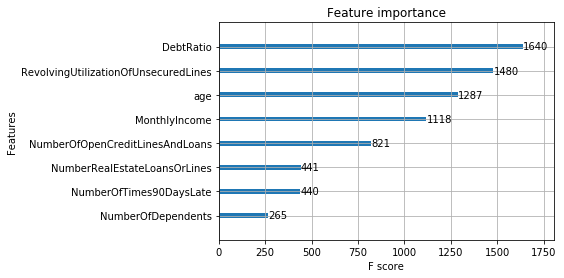

In [60]:
#plot feature importance
plot_importance(model_xgb)
pyplot.show()

----
Let us see how the top important features behaves with the target.

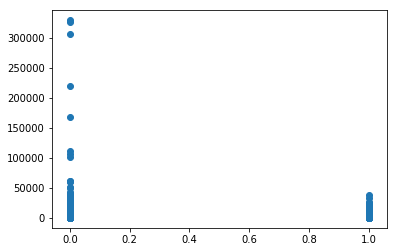

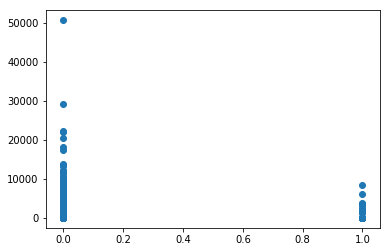

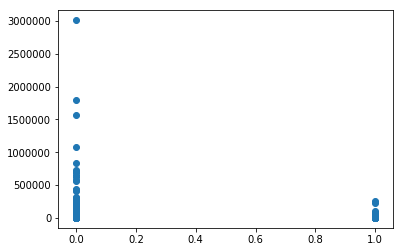

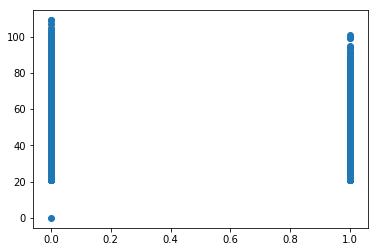

In [69]:
plt.scatter(train['SeriousDlqin2yrs'], train['DebtRatio'])
plt.show()

plt.scatter(train['SeriousDlqin2yrs'], train['RevolvingUtilizationOfUnsecuredLines'])
plt.show()

plt.scatter(train['SeriousDlqin2yrs'], train['MonthlyIncome'])
plt.show()

plt.scatter(train['SeriousDlqin2yrs'], train['age'])
plt.show()

----

Here, we can see that people with low values of DebtRatio, RevolvingUtilizationOfUnsecuredLines, MonthlyIncome tend to face more financial distress. These three are the most important features as well followed by age and others. This is a base model that can be improved(if required) by performing feature engineering, outlier handling, parameter tuning using techniques like GridSearch which might help in better generalization. Moreover, a cost matrix can be created to form a business rule based on threshold values - these rules can be followed to decide to approve or reject a loan application.

In [88]:
# test set prediction
test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [71]:
# Test df predictions
df_test=test.drop(drop_cols, axis=1) #dropping columns

In [72]:
# test
df_test.isnull().sum()

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
DebtRatio                                   0
MonthlyIncome                           20103
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfDependents                       2626
dtype: int64

In [73]:
# median imputation - we are imputing the missing values by the training set's median.
df_test['MonthlyIncome'].fillna(train["MonthlyIncome"].median(), inplace=True)
df_test['NumberOfDependents'].fillna(train["NumberOfDependents"].median(), inplace=True)

In [74]:
# check
df_test.isnull().sum()

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfDependents                      0
dtype: int64

In [75]:
# predicting with the models
predictions_xgb=model_xgb.predict_proba(df_test)[:,1].tolist()
#predictions_rf=random_forest.predict_proba(df_test)[:,1].tolist()

In [80]:
submission = pd.DataFrame({
       "borrower ID": test['Unnamed: 0'],
       "Purchased": predictions_xgb
   })
submission.head()

,Purchased,borrower ID
0,0.112305,1
1,0.055610,2
2,0.015720,3
3,0.034512,4
4,0.139780,5
